# Deep Learning MURA Classification with VGG19

## Load MURA

In [ ]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Download and unzip
!wget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip'

!unzip -o -q MURA-v1.1.zip

--2023-06-22 07:13:50--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  19.4MB/s    in 2m 48s  

2023-06-22 07:16:38 (19.2 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]



In [ ]:
drive_path='/content/drive/My Drive/MURA Challenge/data/'
path='/content/drive/My Drive/MURA Challenge/data/MURA-v1.1/'
colab_path='/content/MURA-v1.1/'

In [ ]:
#Read CSVs
train_imgs_path=pd.read_csv(colab_path+'train_image_paths.csv',dtype=str,header=None,names=['Img_Path'])
train_labels=pd.read_csv(colab_path+'train_labeled_studies.csv',dtype=str,names=['Img_Path','Label'],header=None)
test_imgs_path=pd.read_csv(colab_path+'valid_image_paths.csv',dtype=str,header=None,names=['Img_Path'])
test_labels=pd.read_csv(colab_path+'valid_labeled_studies.csv',dtype=str,names=['Img_Path','Label'],header=None)

## Load Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from tqdm import tqdm
from glob import glob
import gc
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.applications.vgg19 import VGG19
from keras.callbacks import *

## Functions

### Data Preparation

In [ ]:
def keep_dir(dir):
  x=list(dir.split('/'))
  x='/'.join(x[:5])
  x=x+'/'
  return x
def keep_dir2(dir):
  x=list(dir.split('/'))
  x='/'.join(x[3:5])
  x=x+'/'
  return x

In [ ]:
train_imgs_path['path_to_merge']=train_imgs_path['Img_Path'].apply(lambda x: keep_dir(x))
test_imgs_path['path_to_merge']=test_imgs_path['Img_Path'].apply(lambda x: keep_dir(x))

In [ ]:
train_data=train_imgs_path.merge(train_labels,how='inner',left_on='path_to_merge', right_on='Img_Path')
test_data=test_imgs_path.merge(test_labels,how='inner',left_on='path_to_merge', right_on='Img_Path')

In [ ]:
train_data['Body_Part']=train_data['Img_Path_x'].apply(lambda x: str(x.split('/')[2]))
test_data['Body_Part']=test_data['Img_Path_x'].apply(lambda x: str(x.split('/')[2]))
train_data['Patient/Study']=train_data['Img_Path_x'].apply(lambda x: str(x.split('/')[3:5]))
test_data['Patient/Study']=test_data['Img_Path_x'].apply(lambda x: str(x.split('/')[3:5]))
train_data['Patient/Study']=train_data['Img_Path_x'].apply(lambda x: keep_dir2(x) )
test_data['Patient/Study']=test_data['Img_Path_x'].apply(lambda x: keep_dir2(x) )
train_data.drop(columns=['path_to_merge','Img_Path_y'],inplace=True)
train_data.rename(columns={'Img_Path_x':'Img_Path'},inplace=True)
test_data.drop(columns=['path_to_merge','Img_Path_y'],inplace=True)
test_data.rename(columns={'Img_Path_x':'Img_Path'},inplace=True)

test_labels['Body_Part']=test_labels['Img_Path'].apply(lambda x: str(x.split('/')[2]))
test_labels['Patient/Study']=test_labels['Img_Path'].apply(lambda x:  keep_dir2(x))

### Present Data

In [ ]:
train_data.head()

,Img_Path,Label,Body_Part,Patient/Study
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,XR_SHOULDER,patient00001/study1_positive/
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,XR_SHOULDER,patient00001/study1_positive/
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,XR_SHOULDER,patient00001/study1_positive/
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,XR_SHOULDER,patient00002/study1_positive/
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,XR_SHOULDER,patient00002/study1_positive/


In [ ]:
test_data.head()

,Img_Path,Label,Body_Part,Patient/Study
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,XR_WRIST,patient11185/study1_positive/
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,XR_WRIST,patient11185/study1_positive/
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,XR_WRIST,patient11185/study1_positive/
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,XR_WRIST,patient11185/study1_positive/
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,XR_WRIST,patient11186/study1_positive/


### Shuffle Data

In [ ]:
shuffled=train_data.sample(frac=1)
msk = np.random.rand(len(shuffled)) <0.8
train = shuffled[msk]
val= shuffled[~msk]

### Create Evaluation Functions

In [ ]:
#Recall-batch-wise average of recall
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#Precission- batch-wise average of precision
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#F1
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))

#Garbage collection
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

### History Function

In [ ]:
# for visualizing the training progress of our models
def viz_history(hs_dict,metric):
  plt.style.use('dark_background')
  plt.rcParams['figure.figsize'] = [15, 8]
  plt.rcParams['font.size'] = 16
  plt.clf()
  for model in hs_dict.keys():
    plt.plot(hs_dict[model].history[metric],label='{0:s} train {1:s}'.format(model, metric))
    plt.plot(hs_dict[model].history['val_{0:s}'.format(metric)],label='{0:s} validation {1:s}'.format(model, metric))
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend()
  plt.show()

### Model Creation

In [ ]:
#Model Architecture
def configurable_train_model(
        upper_layers_optimizer,
        full_network_optimizer,
        upper_layers_epochs=15,
        full_network_epochs=10,
        body_type='XR_ELBOW',
        input_shape=(224,224,3),
        mlp_hidden_layers=[512],
        mlp_hidden_activation='relu',
        mlp_dropout=0.2,
        output_activation='softmax',
        #Add pretrained model
        pretrained_model=VGG19,
        batch_norm=True,
        callbacks_upper=None,
        callbacks_full=None,
        batch_size=32,
        class_weights=None,
        classes=2,
        verbose=1):

    np.random.seed(1402) # Define seed for reproducible experiments.

    train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      horizontal_flip=True,
  )

    val_datagen=ImageDataGenerator(
        rescale=1./255)

    train_generator=train_datagen.flow_from_dataframe(
        dataframe=train[train.Body_Part==body_type],
        directory=None,
        x_col="Img_Path",
        y_col="Label",
        weight_col=None,
        target_size=(224, 224),
        color_mode="rgb",
        classes=None,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=False,
        seed=1,
        save_to_dir=None,
        save_prefix="",
        save_format="png",
        interpolation="nearest",
        validate_filenames=False,
    )

    val_generator=val_datagen.flow_from_dataframe(
        dataframe=val[val.Body_Part==body_type],
        directory=None,
        x_col="Img_Path",
        y_col="Label",
        weight_col=None,
        target_size=(224, 224),
        color_mode="rgb",
        classes=None,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=False,
        seed=1,
        save_to_dir=None,
        save_prefix="",
        save_format="png",
        interpolation="nearest",
        validate_filenames=False
    )

    #Model parameters for training
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

    base_model =pretrained_model(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    x = base_model.output
    #Define MLP layers
    for i, units in enumerate(mlp_hidden_layers):
        x = Dense(
            units=units,
            kernel_initializer='glorot_uniform',
            activation=mlp_hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        if mlp_dropout > 0:
            x = Dropout(rate=mlp_dropout)(x)

    #Define the output layer
    output = Dense(
        units=classes,
        activation=output_activation,
        name='Output'
    )(x)

    #Define the model
    model = Model(inputs=base_model.input, outputs=output)

    #First train the upper layers for a few epochs
    for layer in base_model.layers:
        layer.trainable = False

    #Compile the Model
    model.compile(optimizer=upper_layers_optimizer, loss='categorical_crossentropy', metrics=['accuracy',f1])
    if class_weights:
      hs_upper_layers = model.fit(
        train_generator,
        epochs=upper_layers_epochs,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=val_generator,
        validation_steps=STEP_SIZE_VALID,
        callbacks=callbacks_upper,
        class_weight=class_weights[body_type],
        verbose=1
      )
    else:
      hs_upper_layers = model.fit(
        train_generator,
        epochs=upper_layers_epochs,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=val_generator,
        validation_steps=STEP_SIZE_VALID,
        callbacks=callbacks_upper,
        verbose=1
      )
    print('Finished training upper layers.')
    print('------------------')

    # Now train with a low learning rate
    for layer in base_model.layers:
        layer.trainable = True

    #Compile the Model
    model.compile(optimizer=full_network_optimizer, loss='categorical_crossentropy', metrics=['accuracy',f1])
    model.summary()
    if class_weights:
      hs_full_network = model.fit(
        train_generator,
        epochs=full_network_epochs,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=val_generator,
        validation_steps=STEP_SIZE_VALID,
        callbacks=callbacks_full,
        class_weight=class_weights[body_type],
        verbose=1
      )
    else:
      hs_full_network = model.fit(
        train_generator,
        epochs=full_network_epochs,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=val_generator,
        validation_steps=STEP_SIZE_VALID,
        callbacks=callbacks_full,
        verbose=1
      )
    print('Finished training full network.')
    print('------------------')

    return model,  hs_full_network


### Model Training

In [ ]:
def train_model(
        optimizer,
        body_type='XR_ELBOW',
        size=224,
        output_activation='softmax',
        full_network_epochs=10,
        callbacks=None,
        batch_size=32,
        verbose=1,
        class_weights=None,
        transfer_model=VGG19,
        batch_norm=True,

        ):

    input_shape=(size,size,3)

    train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      horizontal_flip=True,
  )

    train_generator=train_datagen.flow_from_dataframe(
        dataframe=train[train.Body_Part==body_type],
        directory=None,
        x_col="Img_Path",
        y_col="Label",
        weight_col=None,
        target_size=(size, size),
        color_mode="rgb",
        classes=None,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=False,
        seed=1,
        save_to_dir=None,
        save_prefix="",
        save_format="png",
        interpolation="nearest",
        validate_filenames=False,
    )

    val_datagen=ImageDataGenerator(
        rescale=1./255)

    val_generator=val_datagen.flow_from_dataframe(
        dataframe=val[val.Body_Part==body_type],
        directory=None,
        x_col="Img_Path",
        y_col="Label",
        weight_col=None,
        target_size=(size, size),
        color_mode="rgb",
        classes=None,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=False,
        seed=1,
        save_to_dir=None,
        save_prefix="",
        save_format="png",
        interpolation="nearest",
        validate_filenames=False
    )

    #model parameters for training
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=val_generator.n//val_generator.batch_size


    base_model = transfer_model(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg',
    )

    x = base_model.output
    output = Dense(2, activation='softmax', name='predictions')(x)
    model = Model(inputs=base_model.input, output=output)

    for layer in base_model.layers:
            layer.trainable = True

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',f1])
    if class_weights:
      hs_full_network = model.fit(
        train_generator,
        epochs=full_network_epochs,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=val_generator,
        validation_steps=STEP_SIZE_VALID,
        callbacks=callbacks,
        class_weight=class_weights[body_type],
        verbose=1
      )
    else:
      hs_full_network = model.fit(
        train_generator,
        epochs=full_network_epochs,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=val_generator,
        validation_steps=STEP_SIZE_VALID,
        callbacks=callbacks,
        verbose=1
      )
    model.summary() # Print a description of the model.
    print('Finished training full network.')
    print('------------------')

    return model, hs_full_network

### Evaluation

In [ ]:
from sklearn.metrics import *
def evaluate_model(
    body_part='XR_ELBOW',
    model=None
):
  test_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      horizontal_flip=True,)

  test_generator=test_datagen.flow_from_dataframe(
      dataframe=test_data[test_data.Body_Part==body_part],
      directory=None,
      x_col="Img_Path",
      y_col="Label",
      weight_col=None,
      target_size=(224, 224),
      color_mode="rgb",
      classes=None,
      class_mode="categorical",
      batch_size=128,
      shuffle=False,
      seed=1,
      save_to_dir=None,
      save_prefix="",
      save_format="png",
      interpolation="nearest",
      validate_filenames=False
  )

  tta_steps = 10
  predictions = []

  for i in tqdm(range(tta_steps)):
      preds = model.predict(test_generator,verbose=1)
      predictions.append(preds)


  preds = np.mean(predictions, axis=0)

  voting_df=pd.DataFrame(data=np.c_[test_data[test_data.Body_Part==body_part]['Patient/Study'].values,preds],
                       columns=['Patient/Study','Class 0 prob','Class 1 prob'])

  voting_df[['Class 0 prob', 'Class 1 prob']] = voting_df[['Class 0 prob', 'Class 1 prob']].apply(pd.to_numeric)
  voting_df=voting_df.groupby('Patient/Study').mean().reset_index()
  voting_df['Class_prediction']=np.argmax(voting_df.iloc[:,1:3].values,axis=1)
  voting_df=voting_df.merge(test_labels[test_labels.Body_Part==body_part],how='inner',on='Patient/Study')
  voting_df=voting_df.drop(columns=['Img_Path'])
  voting_df['Label'] = voting_df['Label'].apply(pd.to_numeric)
  kappa_score=cohen_kappa_score(voting_df.Class_prediction,voting_df.Label)
  f1=f1_score(voting_df.Class_prediction,voting_df.Label)
  return [kappa_score,f1,voting_df]

## Body Parts

In [ ]:
path_to_saved_models='/content/drive/My Drive/Deep Learning/vgg_models/'
path_to_saved_hist='/content/drive/My Drive/Deep Learning/vgg_hist/'

In [ ]:
store_results={}

### Elbow

#### Train the model

Found 3909 non-validated image filenames belonging to 2 classes.
Found 1022 non-validated image filenames belonging to 2 classes.
80134624/80134624 [==============================] - 3s 0us/step
Epoch 1/10
122/122 [==============================] - 83s 570ms/step - loss: 0.6909 - accuracy: 0.5760 - f1: 0.5761 - val_loss: 0.6547 - val_accuracy: 0.6542 - val_f1: 0.6542
Epoch 2/10
122/122 [==============================] - 68s 559ms/step - loss: 0.6662 - accuracy: 0.6069 - f1: 0.6082 - val_loss: 0.6535 - val_accuracy: 0.6280 - val_f1: 0.6280
Epoch 3/10
122/122 [==============================] - 75s 612ms/step - loss: 0.6538 - accuracy: 0.6252 - f1: 0.6264 - val_loss: 0.6145 - val_accuracy: 0.6865 - val_f1: 0.6865
Epoch 4/10
122/122 [==============================] - 67s 549ms/step - loss: 0.6550 - accuracy: 0.6229 - f1: 0.6214 - val_loss: 0.6174 - val_accuracy: 0.6744 - val_f1: 0.6744
Epoch 5/10
122/122 [==============================] - 71s 584ms/step - loss: 0.6325 - accuracy: 0.6456 - 

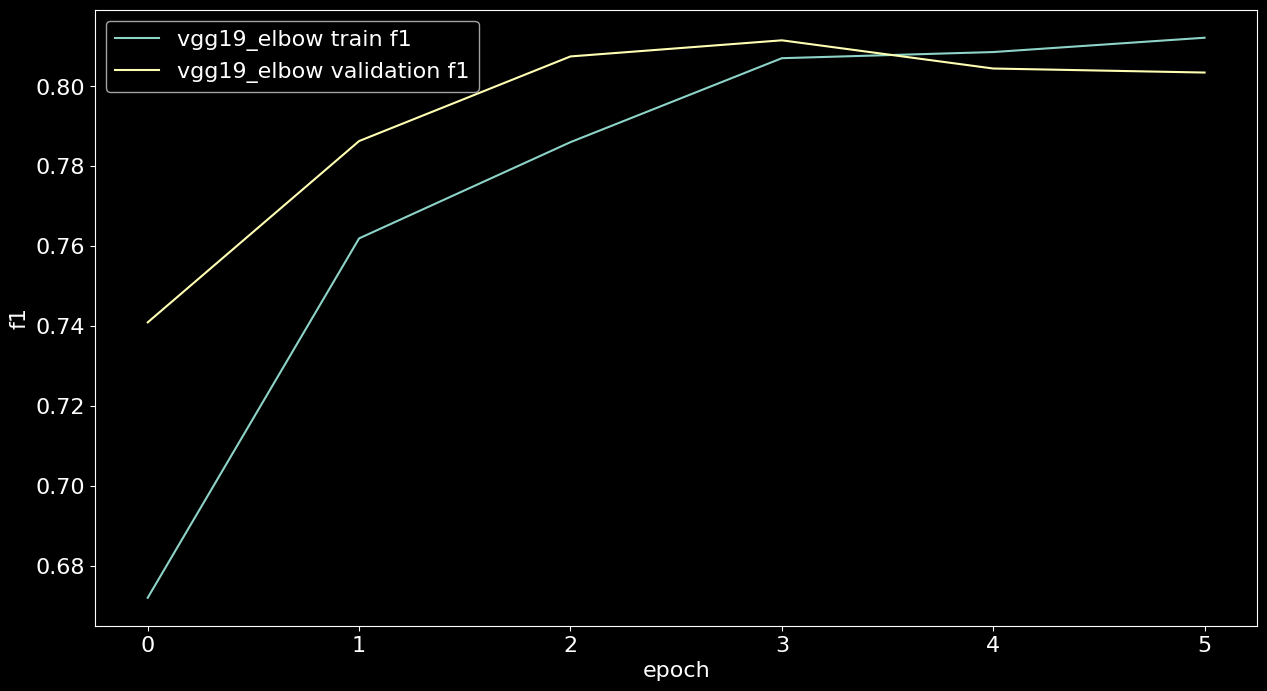

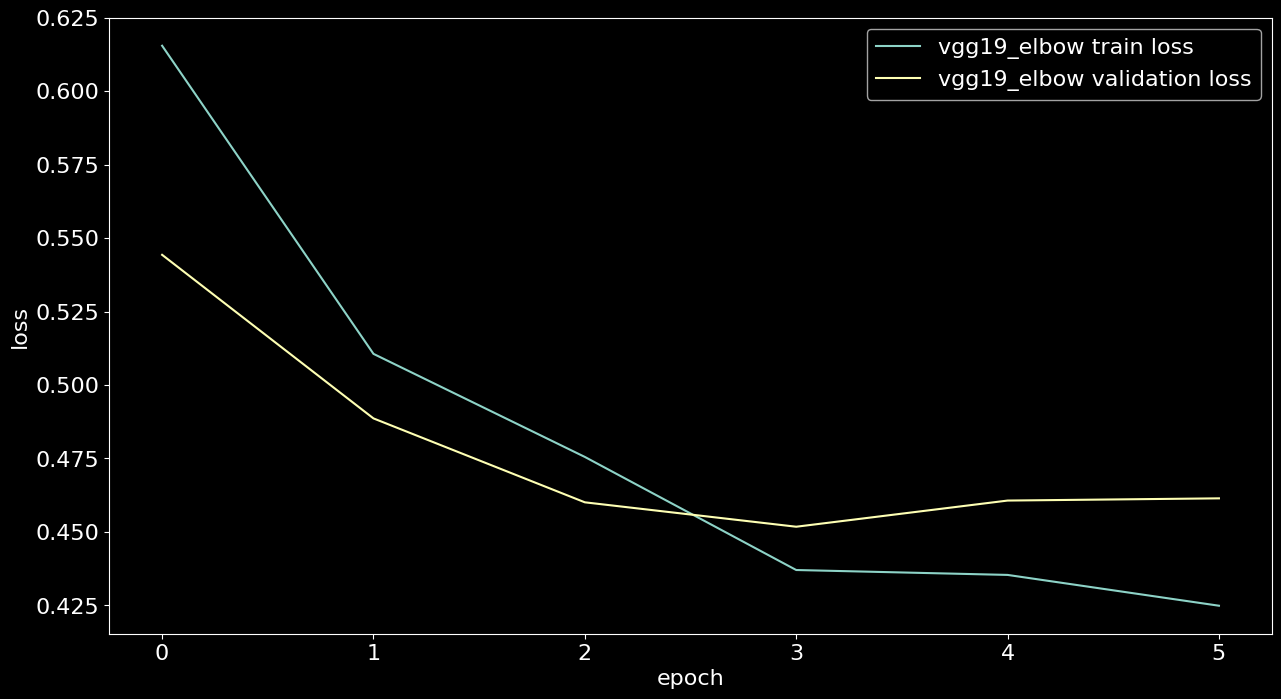

In [ ]:
callbacks_upper= [EarlyStopping(monitor='val_f1', patience=5, verbose=1,restore_best_weights=True)]
callbacks_full = [EarlyStopping(monitor='val_f1', patience=5, verbose=1,restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2,cooldown=2, verbose=1, mode='auto'),
            ModelCheckpoint(filepath=path_to_saved_models+'XR_ELBOW_best_model_vgg19.h5', monitor='val_f1', save_best_only=True)]

upper_layers_optimizer = Adam()
full_network_optimizer = Adam(1e-5)

vgg19_model,vgg19_hs = configurable_train_model(batch_size=32,
                                                mlp_hidden_layers=[512],
                                                full_network_epochs=15,
                                                upper_layers_epochs=10,
                                                upper_layers_optimizer=upper_layers_optimizer,
                                                full_network_optimizer=full_network_optimizer,
                                                body_type='XR_ELBOW',
                                                output_activation='softmax',
                                                class_weights=None,
                                                callbacks_upper=callbacks_upper,
                                                callbacks_full=callbacks_full,
                                                verbose=1)



viz_history(hs_dict={'vgg19_elbow':vgg19_hs},metric='f1')
viz_history(hs_dict={'vgg19_elbow':vgg19_hs},metric='loss')

#### Evaluate the results

In [ ]:
test_datagen = ImageDataGenerator(
      rescale=1./255,
      )

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_data[test_data.Body_Part=='XR_ELBOW'],
    directory=None,
    x_col="Img_Path",
    y_col="Label",
    weight_col=None,
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=128,
    shuffle=False,
    seed=1,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    interpolation="nearest",
    validate_filenames=False
)


Found 465 non-validated image filenames belonging to 2 classes.


In [ ]:
pred_tmp=vgg19_model.predict(test_generator,verbose=1)

4/4 [==============================] - 31s 4s/step


In [ ]:
y_pred=np.argmax(pred_tmp,axis=1)
true_labels=np.asarray(list(map(int, test_data[test_data.Body_Part=='XR_ELBOW'].Label.values)))
cohen_kappa_score(true_labels,y_pred)

0.5740063850460371

In [ ]:
store_results['vgg_elbow_no_class_weights']=evaluate_model(body_part='XR_ELBOW',model=vgg19_model)

Found 465 non-validated image filenames belonging to 2 classes.


  0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 9s 2s/step


 10%|█         | 1/10 [00:10<01:37, 10.78s/it]

4/4 [==============================] - 7s 2s/step


 20%|██        | 2/10 [00:19<01:17,  9.65s/it]

4/4 [==============================] - 7s 2s/step


 30%|███       | 3/10 [00:29<01:09,  9.95s/it]

4/4 [==============================] - 9s 2s/step


 40%|████      | 4/10 [00:40<01:01, 10.22s/it]

4/4 [==============================] - 7s 2s/step


 50%|█████     | 5/10 [00:49<00:48,  9.76s/it]

4/4 [==============================] - 7s 2s/step


 60%|██████    | 6/10 [00:59<00:39, 10.00s/it]

4/4 [==============================] - 9s 2s/step


 70%|███████   | 7/10 [01:10<00:30, 10.27s/it]

4/4 [==============================] - 7s 2s/step


 80%|████████  | 8/10 [01:19<00:19,  9.87s/it]

4/4 [==============================] - 7s 2s/step


 90%|█████████ | 9/10 [01:30<00:10, 10.03s/it]

4/4 [==============================] - 9s 2s/step


100%|██████████| 10/10 [01:41<00:00, 10.10s/it]


In [ ]:
store_results['vgg_elbow_no_class_weights'][0]

0.597623089983022

In [ ]:
for k,v in store_results.items():
  print('{}: Kappa Score {:.3f} f1 {:.3f}'.format(k,v[0],v[1]))

vgg_elbow_no_class_weights: Kappa Score 0.598 f1 0.746


### Finger

#### Train the model

Found 4099 non-validated image filenames belonging to 2 classes.
Found 1007 non-validated image filenames belonging to 2 classes.
Epoch 1/10
128/128 [==============================] - 76s 589ms/step - loss: 0.6318 - accuracy: 0.6263 - f1: 0.6289 - val_loss: 0.5616 - val_accuracy: 0.6946 - val_f1: 0.6946
Epoch 2/10
128/128 [==============================] - 68s 530ms/step - loss: 0.5990 - accuracy: 0.6504 - f1: 0.6528 - val_loss: 0.5592 - val_accuracy: 0.6986 - val_f1: 0.6986
Epoch 3/10
128/128 [==============================] - 72s 557ms/step - loss: 0.5841 - accuracy: 0.6666 - f1: 0.6689 - val_loss: 0.5380 - val_accuracy: 0.7188 - val_f1: 0.7188
Epoch 4/10
128/128 [==============================] - 69s 541ms/step - loss: 0.5745 - accuracy: 0.6759 - f1: 0.6782 - val_loss: 0.5443 - val_accuracy: 0.6986 - val_f1: 0.6986
Epoch 5/10
128/128 [==============================] - 68s 531ms/step - loss: 0.5775 - accuracy: 0.6737 - f1: 0.6760 - val_loss: 0.5594 - val_accuracy: 0.6734 - val_f1: 0.

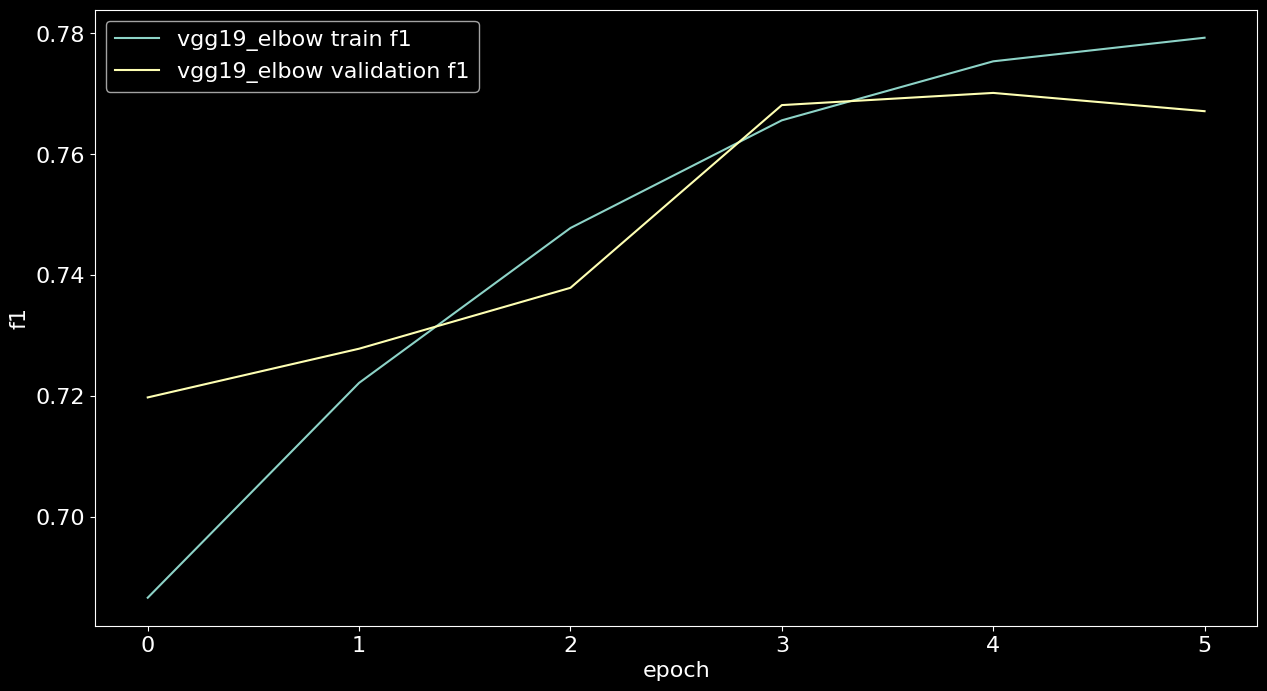

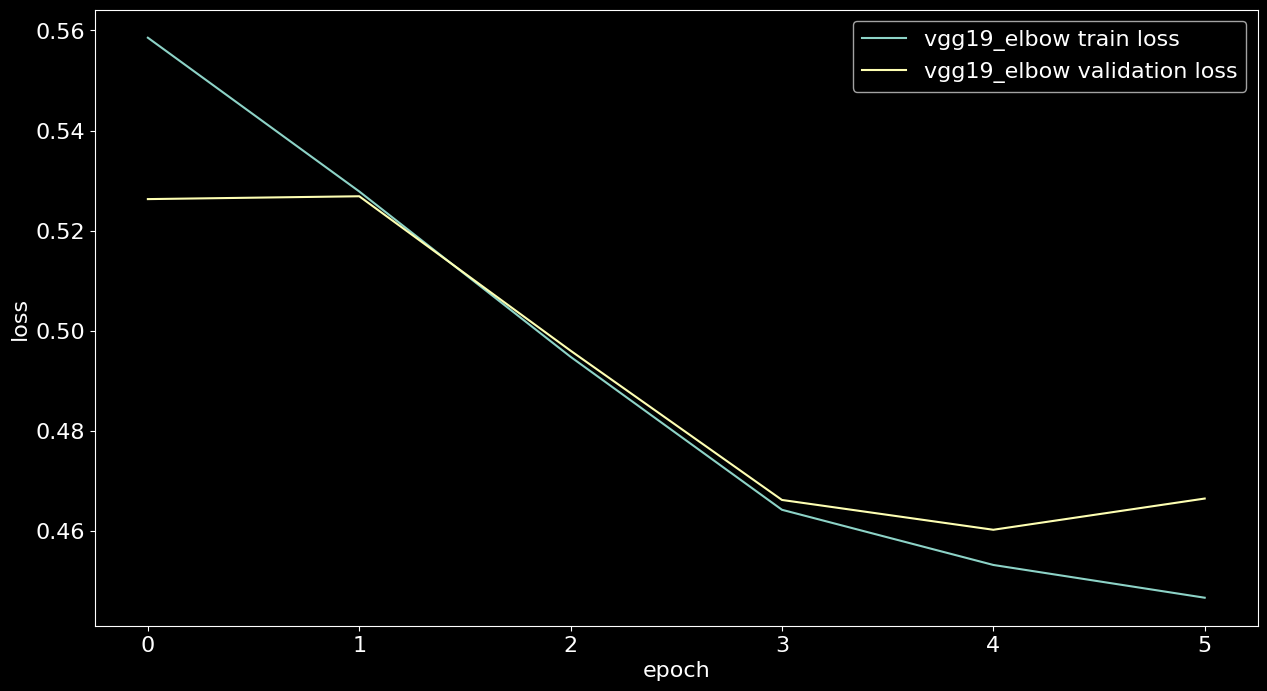

In [ ]:
callbacks_upper= [EarlyStopping(monitor='val_f1', patience=5, verbose=1,restore_best_weights=True)]
callbacks_full = [EarlyStopping(monitor='val_f1', patience=5, verbose=1,restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2,cooldown=2, verbose=1, mode='auto'),
            ModelCheckpoint(filepath=path_to_saved_models+'XR_FINGER_best_model_vgg19.h5', monitor='val_f1', save_best_only=True)]

upper_layers_optimizer = Adam()
full_network_optimizer = Adam(1e-5)


vgg19_model,vgg19_hs = configurable_train_model(batch_size=32,
                                                mlp_hidden_layers=[512],
                                                full_network_epochs=15,
                                                upper_layers_epochs=10,
                                                upper_layers_optimizer=upper_layers_optimizer,
                                                full_network_optimizer=full_network_optimizer,
                                                body_type='XR_FINGER',
                                                output_activation='softmax',
                                                class_weights=None,
                                                callbacks_upper=callbacks_upper,
                                                callbacks_full=callbacks_full,
                                                verbose=1)



viz_history(hs_dict={'vgg19_finger':vgg19_hs},metric='f1')
viz_history(hs_dict={'vgg19_finger':vgg19_hs},metric='loss')

#### Evaluate the Results

In [ ]:
test_datagen = ImageDataGenerator(
      rescale=1./255,
      )

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_data[test_data.Body_Part=='XR_FINGER'],
    directory=None,
    x_col="Img_Path",
    y_col="Label",
    weight_col=None,
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=128,
    shuffle=False,
    seed=1,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    interpolation="nearest",
    validate_filenames=False
)

Found 461 non-validated image filenames belonging to 2 classes.


In [ ]:
pred_tmp=vgg19_model.predict(test_generator,verbose=1)

4/4 [==============================] - 13s 4s/step


In [ ]:
y_pred=np.argmax(pred_tmp,axis=1)
true_labels=np.asarray(list(map(int, test_data[test_data.Body_Part=='XR_FINGER'].Label.values)))
cohen_kappa_score(true_labels,y_pred)

0.34541060530547374

In [ ]:
store_results['vgg_elbow_no_class_weights'][0]

0.5336805555555556

In [ ]:
store_results['vgg_finger_no_class_weights']=evaluate_model(body_part='XR_FINGER',model=vgg19_model)

Found 461 non-validated image filenames belonging to 2 classes.


  0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 8s 2s/step


 10%|█         | 1/10 [00:10<01:31, 10.20s/it]

4/4 [==============================] - 7s 2s/step


 20%|██        | 2/10 [00:18<01:13,  9.17s/it]

4/4 [==============================] - 7s 2s/step


 30%|███       | 3/10 [00:28<01:06,  9.54s/it]

4/4 [==============================] - 8s 2s/step


 40%|████      | 4/10 [00:39<00:59,  9.87s/it]

4/4 [==============================] - 7s 2s/step


 50%|█████     | 5/10 [00:47<00:46,  9.37s/it]

4/4 [==============================] - 8s 2s/step


 60%|██████    | 6/10 [00:58<00:39,  9.77s/it]

4/4 [==============================] - 8s 2s/step


 70%|███████   | 7/10 [01:08<00:29,  9.91s/it]

4/4 [==============================] - 6s 2s/step


 80%|████████  | 8/10 [01:16<00:18,  9.43s/it]

4/4 [==============================] - 8s 2s/step


 90%|█████████ | 9/10 [01:26<00:09,  9.67s/it]

4/4 [==============================] - 8s 2s/step


100%|██████████| 10/10 [01:36<00:00,  9.67s/it]


In [ ]:
for k,v in store_results.items():
  print('{}: Kappa Score {:.3f} f1 {:.3f}'.format(k,v[0],v[1]))

vgg_elbow_no_class_weights: Kappa Score 0.534 f1 0.685
vgg_finger_no_class_weights: Kappa Score 0.428 f1 0.702


### Wrist

#### Train the Model

Found 7839 non-validated image filenames belonging to 2 classes.
Found 1913 non-validated image filenames belonging to 2 classes.
Epoch 1/10
244/244 [==============================] - 158s 645ms/step - loss: 0.6308 - accuracy: 0.6367 - f1: 0.6367 - val_loss: 0.5858 - val_accuracy: 0.6753 - val_f1: 0.6753
Epoch 2/10
244/244 [==============================] - 151s 619ms/step - loss: 0.6054 - accuracy: 0.6609 - f1: 0.6609 - val_loss: 0.6180 - val_accuracy: 0.6584 - val_f1: 0.6584
Epoch 3/10
244/244 [==============================] - 141s 580ms/step - loss: 0.5859 - accuracy: 0.6844 - f1: 0.6844 - val_loss: 0.5762 - val_accuracy: 0.6917 - val_f1: 0.6917
Epoch 4/10
244/244 [==============================] - 146s 596ms/step - loss: 0.5836 - accuracy: 0.6871 - f1: 0.6871 - val_loss: 0.5960 - val_accuracy: 0.6785 - val_f1: 0.6785
Epoch 5/10
244/244 [==============================] - 143s 587ms/step - loss: 0.5784 - accuracy: 0.6922 - f1: 0.6922 - val_loss: 0.5591 - val_accuracy: 0.6992 - val_f

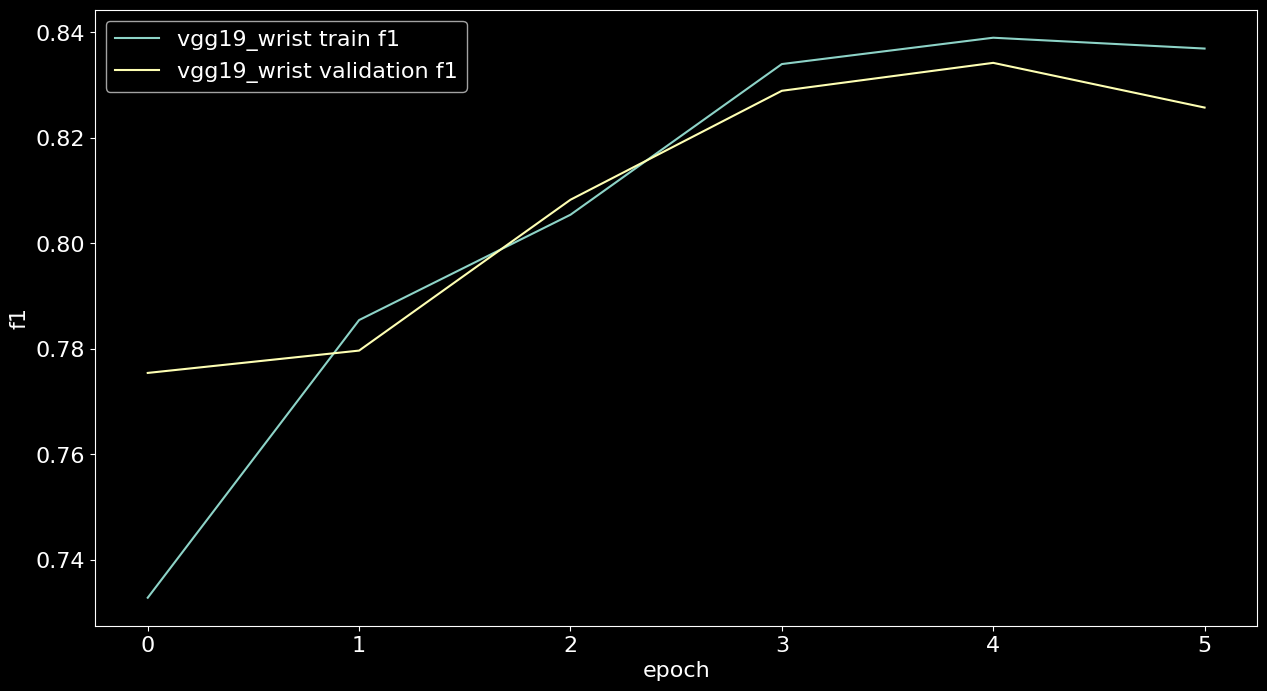

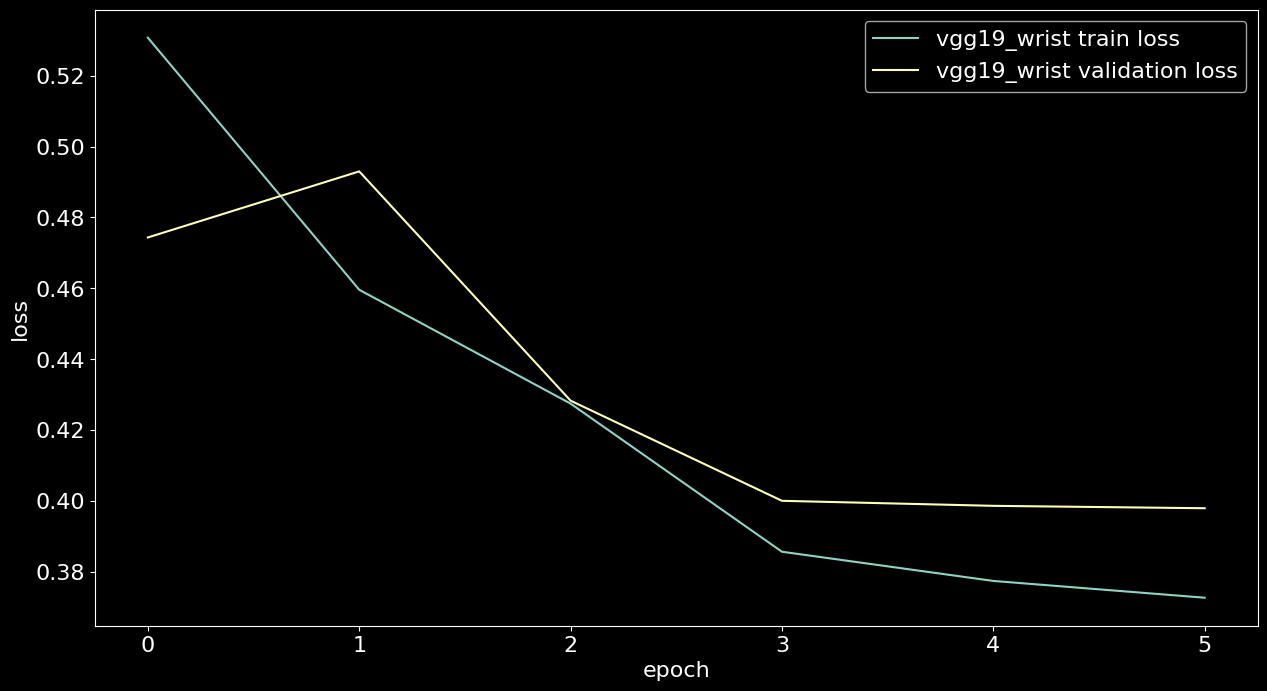

In [ ]:
callbacks_upper= [EarlyStopping(monitor='val_f1', patience=5, verbose=1,restore_best_weights=True)]
callbacks_full = [EarlyStopping(monitor='val_f1', patience=5, verbose=1,restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2,cooldown=2, verbose=1, mode='auto'),
            ModelCheckpoint(filepath=path_to_saved_models+'XR_WRIST_best_model_vgg19.h5', monitor='val_f1', save_best_only=True)]

upper_layers_optimizer = Adam()
full_network_optimizer = Adam(1e-5)


vgg19_model,vgg19_hs = configurable_train_model(batch_size=32,
                                                mlp_hidden_layers=[512],
                                                full_network_epochs=15,
                                                upper_layers_epochs=10,
                                                upper_layers_optimizer=upper_layers_optimizer,
                                                full_network_optimizer=full_network_optimizer,
                                                body_type='XR_WRIST',
                                                output_activation='softmax',
                                                class_weights=None,
                                                callbacks_upper=callbacks_upper,
                                                callbacks_full=callbacks_full,
                                                verbose=1)



viz_history(hs_dict={'vgg19_wrist':vgg19_hs},metric='f1')
viz_history(hs_dict={'vgg19_wrist':vgg19_hs},metric='loss')

#### Evaluate the Results

In [ ]:
test_datagen = ImageDataGenerator(
      rescale=1./255,
      )

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_data[test_data.Body_Part=='XR_WRIST'],
    directory=None,
    x_col="Img_Path",
    y_col="Label",
    weight_col=None,
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=128,
    shuffle=False,
    seed=1,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    interpolation="nearest",
    validate_filenames=False
)

Found 659 non-validated image filenames belonging to 2 classes.


In [ ]:
pred_tmp=vgg19_model.predict(test_generator,verbose=1)

6/6 [==============================] - 8s 1s/step


In [ ]:
y_pred=np.argmax(pred_tmp,axis=1)
true_labels=np.asarray(list(map(int, test_data[test_data.Body_Part=='XR_WRIST'].Label.values)))

In [ ]:
store_results['vgg_wrist_no_class_weights']=evaluate_model(body_part='XR_WRIST',model=vgg19_model)

Found 659 non-validated image filenames belonging to 2 classes.


  0%|          | 0/10 [00:00<?, ?it/s]

6/6 [==============================] - 12s 2s/step


 10%|█         | 1/10 [00:13<02:02, 13.66s/it]

6/6 [==============================] - 12s 2s/step


 20%|██        | 2/10 [00:27<01:48, 13.52s/it]

6/6 [==============================] - 12s 2s/step


 30%|███       | 3/10 [00:40<01:35, 13.63s/it]

6/6 [==============================] - 12s 2s/step


 40%|████      | 4/10 [00:54<01:22, 13.67s/it]

6/6 [==============================] - 11s 2s/step


 50%|█████     | 5/10 [01:07<01:06, 13.37s/it]

6/6 [==============================] - 10s 2s/step


 60%|██████    | 6/10 [01:19<00:51, 12.93s/it]

6/6 [==============================] - 10s 2s/step


 70%|███████   | 7/10 [01:32<00:39, 13.09s/it]

6/6 [==============================] - 11s 2s/step


 80%|████████  | 8/10 [01:46<00:26, 13.26s/it]

6/6 [==============================] - 12s 2s/step


 90%|█████████ | 9/10 [02:00<00:13, 13.35s/it]

6/6 [==============================] - 12s 2s/step


100%|██████████| 10/10 [02:13<00:00, 13.37s/it]


In [ ]:
store_results['vgg_wrist_no_class_weights'][0]

0.4986345628678026

In [ ]:
cohen_kappa_score(true_labels,y_pred)

0.5034006422102014

## Comulative Results

In [ ]:
for k,v in store_results.items():
  print('{}: Kappa Score {:.3f} f1 {:.3f}'.format(k,v[0],v[1]))

vgg_elbow_no_class_weights: Kappa Score 0.534 f1 0.685
vgg_finger_no_class_weights: Kappa Score 0.428 f1 0.702
vgg_wrist_no_class_weights: Kappa Score 0.499 f1 0.671
